In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
from scipy.special import erf

az.rcParams["plot.max_subplots"] = 80

First, load the output of our inference as an arviz InferenceData object:

In [2]:
#data = az.from_netcdf("ar_lnm1_q_entropy.cdf")
#data = az.from_netcdf("/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/final-ar_lnm1_q.cdf")
data = az.from_netcdf("/Volumes/LaCie/cca/autoregressive-bbh-inference-data/final-ar_lnm1_q.cdf")
az.summary(data,["ar_lnm1_std",
                 "ar_lnm1_tau",
                 "ar_q_std",
                 "ar_q_tau",
                 "kappa",
                 "mu_chi",
                 "logsig_chi",
                 "sig_cost",
                 "nEff_inj_per_event",
                 "min_log_neff"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar_lnm1_std,2.516,0.718,1.307,3.859,0.011,0.008,4057.0,3492.0,1.0
ar_lnm1_tau,3.144,2.173,0.425,7.032,0.035,0.025,4124.0,3606.0,1.0
ar_q_std,0.838,0.609,0.003,1.930,0.011,0.008,2043.0,1464.0,1.0
ar_q_tau,2.001,2.400,0.044,5.943,0.040,0.031,4883.0,3650.0,1.0
kappa,2.981,1.078,1.018,4.942,0.015,0.011,4972.0,3305.0,1.0
mu_chi,0.148,0.075,0.001,0.253,0.002,0.001,2223.0,1704.0,1.0
logsig_chi,-0.746,0.132,-1.000,-0.550,0.003,0.002,2190.0,1781.0,1.0
sig_cost,1.152,0.272,0.702,1.677,0.007,0.005,2207.0,958.0,1.0
nEff_inj_per_event,32.226,16.291,7.552,61.091,0.283,0.200,3511.0,3767.0,1.0
min_log_neff,1.391,0.389,0.732,2.121,0.007,0.005,2945.0,3194.0,1.0


In [3]:
samps = az.extract(data,var_names=["ar_lnm1_std","ar_lnm1_tau","ar_q_std","ar_q_tau"])

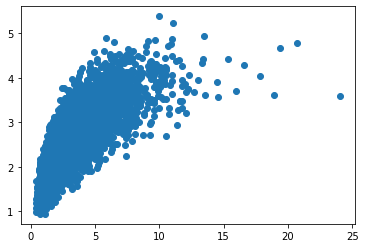

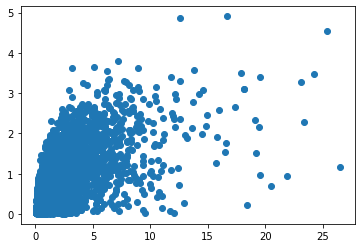

In [5]:
fig,ax = plt.subplots()
ax.scatter(samps.ar_lnm1_tau,samps.ar_lnm1_std)
plt.show()

fig,ax = plt.subplots()
ax.scatter(samps.ar_q_tau,samps.ar_q_std)
plt.show()

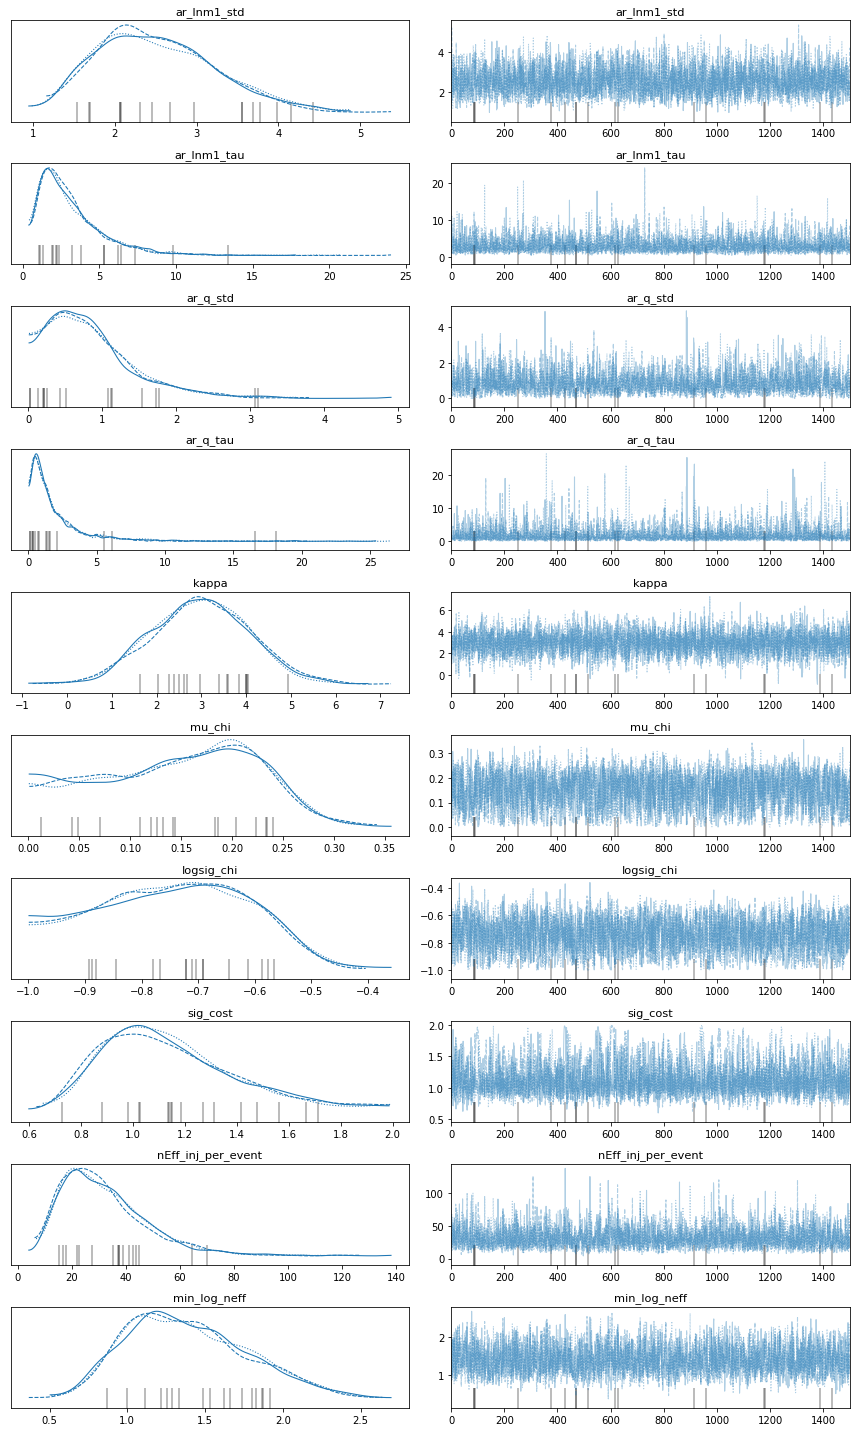

In [3]:
az.plot_trace(data,
              ["ar_lnm1_std",
                 "ar_lnm1_tau",
                 "ar_q_std",
                 "ar_q_tau",
                 "kappa",
                 "mu_chi",
                 "logsig_chi",
                 "sig_cost",
                 "nEff_inj_per_event",
                 "min_log_neff"], compact=True)
plt.tight_layout()
plt.show()

In [4]:
lnm1_q_data = np.load('/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/final-ar_lnm1_q_data.npy',allow_pickle=True)[()]
m_values = np.exp(lnm1_q_data['all_lnm1_samples'])
q_values = lnm1_q_data['all_q_samples']

In [5]:
samps = data.posterior.stack(draws=("chain", "draw"))

In [6]:
f_q_ref = samps.f_qs.values[-1]
f_lnm1_ref = samps.f_lnm1s[lnm1_q_data["ind_m20"],:]

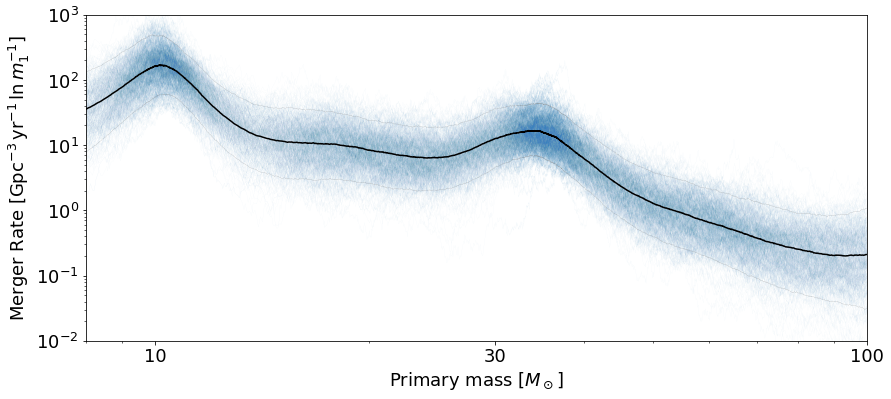

In [7]:
reduced_ms = m_values[::50]
reduced_f_lnm1s = samps['f_lnm1s'][::50]

dR_dlnm1s = np.zeros((reduced_ms.size,reduced_f_lnm1s.shape[1]))
for i in range(reduced_f_lnm1s.shape[1]):
    dR_dlnm1s[:,i] = samps.R20[i]*reduced_f_lnm1s[:,i]*f_q_ref[i]

fig,ax = plt.subplots(figsize=(14,6))
for i in np.random.choice(range(reduced_f_lnm1s.shape[1]),500):
    ax.plot(reduced_ms,dR_dlnm1s[:,i],color='#3182bd',alpha=0.1,lw=0.1,zorder=0)

ax.plot(reduced_ms,np.median(dR_dlnm1s,axis=1),color='black')
ax.plot(reduced_ms,np.quantile(dR_dlnm1s,0.05,axis=1),color='grey',lw=0.15)
ax.plot(reduced_ms,np.quantile(dR_dlnm1s,0.95,axis=1),color='grey',lw=0.15)

#ax.plot(reduced_ms,dR_dlnm1s[:,43],color='black',lw=2,ls='--')
#ax.plot(reduced_ms,dR_dlnm1s[:,74],color='black',lw=2,ls='--')

ax.tick_params(labelsize=18)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,1e3)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=18)
ax.set_ylabel('Merger Rate [$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]',fontsize=18)

plt.show()

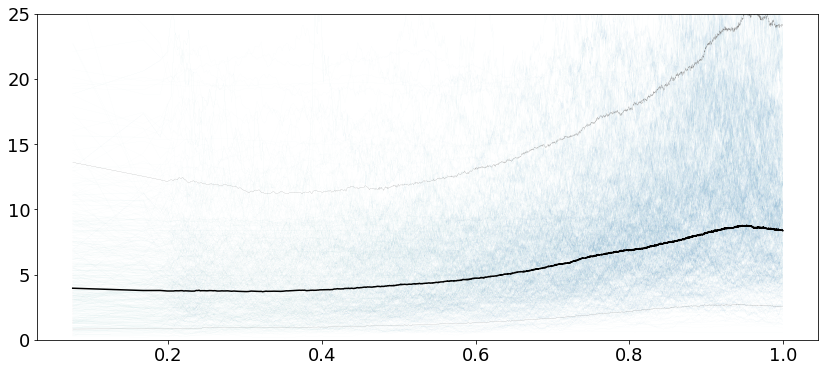

In [8]:
reduced_qs = q_values[::50]
reduced_f_qs = samps['f_qs'][::50]

p_qs = np.zeros((reduced_qs.size,reduced_f_qs.shape[1]))
for i in range(reduced_f_qs.shape[1]):
    p_qs[:,i] = samps.R20[i]*reduced_f_qs[:,i]*f_lnm1_ref[i]

fig,ax = plt.subplots(figsize=(14,6))
random_inds = np.random.choice(np.arange(reduced_f_qs.shape[1]),500)
for i in random_inds:
    ax.plot(reduced_qs,samps.R20[i]*reduced_f_qs[:,i]*f_lnm1_ref[i],color='#3182bd',alpha=0.09,lw=0.09,zorder=0)

ax.plot(reduced_qs,np.median(p_qs,axis=1),color='black')
ax.plot(reduced_qs,np.quantile(p_qs,0.05,axis=1),color='grey',lw=0.15)
ax.plot(reduced_qs,np.quantile(p_qs,0.95,axis=1),color='grey',lw=0.15)

ax.tick_params(labelsize=18)
ax.set_ylim(0,25)

plt.show()

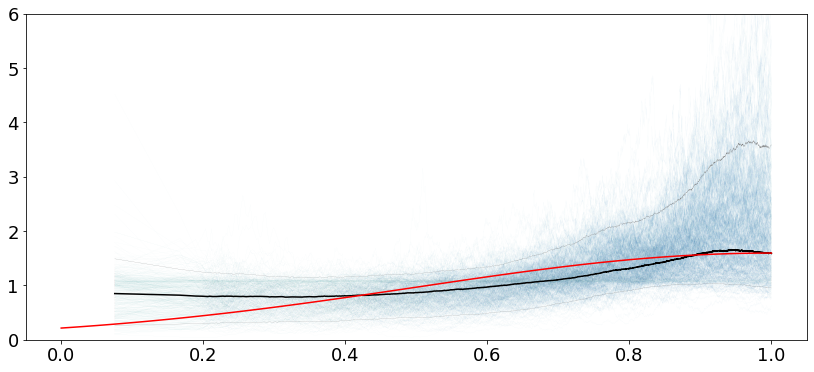

In [9]:
reduced_qs = q_values[::50]
reduced_f_qs = samps['f_qs'][::50]

p_qs = np.zeros((reduced_qs.size,reduced_f_qs.shape[1]))
for i in range(reduced_f_qs.shape[1]):
    p_qs[:,i] = reduced_f_qs[:,i]/np.trapz(reduced_f_qs[:,i],reduced_qs)

fig,ax = plt.subplots(figsize=(14,6))
random_inds = np.random.choice(np.arange(reduced_f_qs.shape[1]),500)
for i in random_inds:
    ax.plot(reduced_qs,p_qs[:,i],color='#3182bd',alpha=0.09,lw=0.09,zorder=0)

ax.plot(reduced_qs,np.median(p_qs,axis=1),color='black')
ax.plot(reduced_qs,np.quantile(p_qs,0.05,axis=1),color='grey',lw=0.15)
ax.plot(reduced_qs,np.quantile(p_qs,0.95,axis=1),color='grey',lw=0.15)

qs = np.linspace(0.,1,100)
p_qs = np.exp(-(qs-1.)**2/(2.*0.5**2))*2/np.sqrt(2.*np.pi*0.5**2)
ax.plot(qs,p_qs,color='red')

ax.tick_params(labelsize=18)
ax.set_ylim(0,6)
#ax.set_yscale('log')

plt.show()

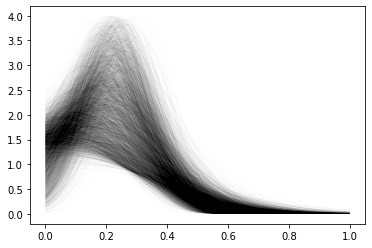

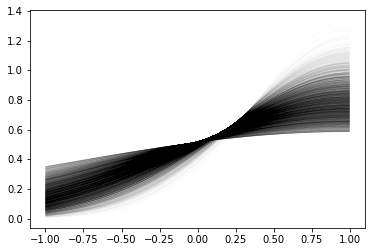

In [10]:
def gaussian(samples,mu,sigma,lowCutoff,highCutoff):
    
    """
    Function defining the probability density due to a truncated Gaussian
    """
    
    a = (lowCutoff-mu)/np.sqrt(2*sigma**2)
    b = (highCutoff-mu)/np.sqrt(2*sigma**2)
    norm = np.sqrt(sigma**2*np.pi/2)*(-erf(a) + erf(b))
    return np.exp(-(samples-mu)**2/(2.*sigma**2))/norm

fig,ax = plt.subplots()
grid = np.linspace(0,1,1000)
for i in range(samps.mu_chi.size):
    
    p_chi = gaussian(grid,samps.mu_chi.values[i],10.**samps.logsig_chi.values[i],-1,1)
    ax.plot(grid,p_chi,color='black',lw=0.1,alpha=0.1)
plt.show()

fig,ax = plt.subplots()
grid = np.linspace(-1,1,1000)
for i in range(samps.mu_chi.size):
    
    #p_cost = gaussian(grid,samps.mu_cost.values[i],samps.sig_cost.values[i],-1,1)
    p_cost = gaussian(grid,1.,samps.sig_cost.values[i],-1,1)

    ax.plot(grid,p_cost,color='black',lw=0.1,alpha=0.1)
plt.show()